# Computing the energy of metaphosphate on IBM

## Set experiment parameters

In [40]:
ibm_computer: str = "ibm_fez"
qubits = [104, 105, 106, 107] + list(range(116, 155 + 1))
nshots: int = 1_000_000

len(qubits)

44

## Setup

In [2]:
from collections import Counter

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import numpy as np
import pickle

import openfermion as of

import qiskit
from qiskit import qasm3
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [3]:
# Skip this cell if not running on hardware.
service = qiskit_ibm_runtime.QiskitRuntimeService(name="NERSC-US")
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

## Read in the Hamiltonian and ansatz circuit

In [4]:
data = np.load("hamiltonians/owp_reactant.npz")

# Get core energy and one-/two-body tensors
ecore = data['ECORE']
h1 = np.array(data['H1'])
h2 = np.array(data['H2'])
norb = data["NORB"]

# Get number of alpha and beta electrons
n_a = int(data["NELEC"]/2)
n_b = int(data["NELEC"]/2)

h2 = 0.5 * np.asarray(h2.transpose(0, 2, 3, 1), order="C")
h1_new, h2_new = of.chem.molecular_data.spinorb_from_spatial(h1, h2)

# Get the Hamiltonian and transform it to FermionOperator
h = of.InteractionOperator(ecore.item(), h1_new, h2_new)

hamiltonian = of.get_fermion_operator(h)
# hamiltonian.compress(0.001)

nqubits = of.utils.count_qubits(hamiltonian)
nterms = len(hamiltonian.terms)

print(f"Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")

Hamiltonian acts on 44 qubit(s) and has 937977 term(s).


In [5]:
hamiltonian = of.jordan_wigner(hamiltonian)

In [6]:
nqubits = of.utils.count_qubits(hamiltonian)
nterms = len(hamiltonian.terms)

print(f"Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")

Hamiltonian acts on 44 qubit(s) and has 575751 term(s).


In [7]:
# hamiltonian_cirq = of.qubit_operator_to_pauli_sum(hamiltonian)

In [36]:
circuit_dir = "circuits/"
circuit_fname = "po3_1w-22o_product.qasm"
# circuit_fname = "circuits/po3_2w-28o_reactant.qasm"
# circuit_fname = "circuits/po3_2w-28o_product.qasm"

In [41]:
circuit = qasm3.load(circuit_dir + circuit_fname)
# circuit.draw(fold=-1)

In [42]:
base = circuit.copy()
base = qiskit.transpiler.passes.RemoveBarriers()(base)

In [43]:
base.count_ops()

OrderedDict([('cx', 1147),
             ('ry', 639),
             ('h', 355),
             ('x', 316),
             ('rz', 228),
             ('cz', 28),
             ('rx', 25)])

## Prepare to run on hardware

In [44]:
to_run = base.copy()
to_run = [to_run]

for c in to_run:
    c.measure_all()

In [45]:
to_run = qiskit.transpile(
    to_run,
    optimization_level=3,
    backend=computer,
    initial_layout=qubits,
)

In [46]:
for c in to_run:
    print(c.count_ops())

OrderedDict([('sx', 8419), ('cz', 4289), ('rz', 3074), ('measure', 44), ('x', 18), ('barrier', 1)])


In [47]:
to_run[0].depth()

4998

In [48]:
ops = list(to_run[0].count_ops().keys())
num = list(to_run[0].count_ops().values())

In [49]:
sum([number for op, number in to_run[0].count_ops().items() if op != "cz"])

11556

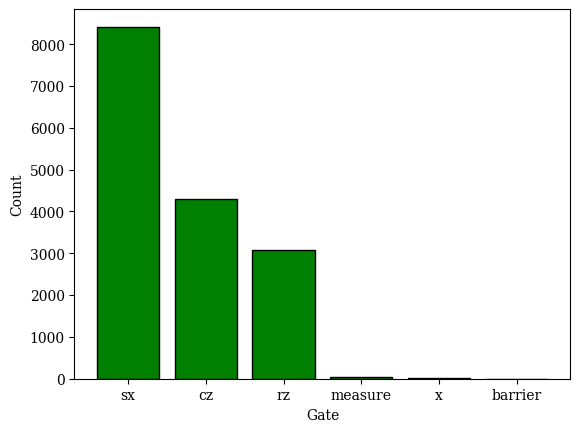

In [50]:
plt.bar(ops, num, color="green", edgecolor="black")
plt.xlabel("Gate")
plt.ylabel("Count");

In [51]:
# to_run[0].draw(fold=-1, idle_wires=False)

## Run on exact simulator

In [ ]:
simulator = AerSimulator(method="matrix_product_state")
result = simulator.run(to_run, shots=1000)
counts = result.result().get_counts()
counts

In [ ]:
hartree_fock_bitstring = list(counts.keys())[0]
hartree_fock_bitstring

## Run on noisy simulator

In [ ]:
sim = AerSimulator.from_backend(computer, method="matrix_product_state")

In [ ]:
result = sim.run(to_run, shots=nshots)
counts = result.result().get_counts()

In [ ]:
qiskit.visualization.plot_histogram(
    counts,
    target_string=hartree_fock_bitstring,
    sort="hamming",
    number_to_keep=10,
    figsize=(7, 8),
    title=sim.name,
)

In [ ]:
pickle.dump(counts, open(f"owp_counts_{sim.name}.pkl", "wb"))

In [ ]:
counts = pickle.load(open(f"owp_counts_{sim.name}.pkl", "rb"))

## Run on hardware

In [52]:
job = sampler.run(to_run, shots=nshots)
# job = service.job("d4b6fasi51bc738iopr0")

In [53]:
all_counts_hardware = []

In [54]:
res = job.result()

In [55]:
for r in res:
    all_counts_hardware.append(r.data.meas.get_counts())

In [56]:
len(all_counts_hardware[0])

1000000

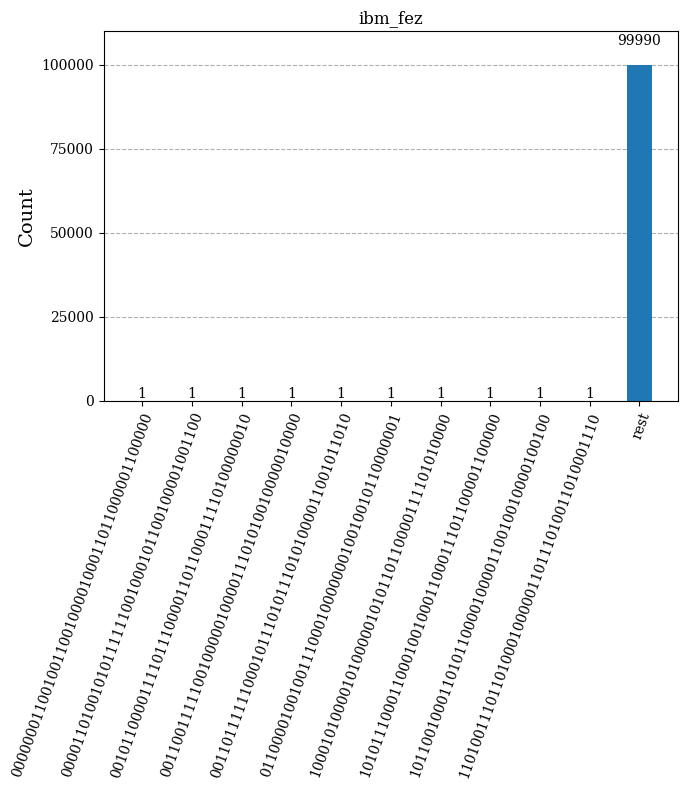

In [34]:
qiskit.visualization.plot_histogram(
    all_counts_hardware[0],
    # target_string=hartree_fock_bitstring,
    # sort="hamming",
    number_to_keep=10,
    figsize=(7, 8),
    title=computer.name,
)

## Save data

In [57]:
import datetime


time_key = datetime.datetime.now().strftime("%Y_%m_%d_%H:%M:%S")
fname = circuit_fname + f"_counts_{computer.name}_nshots_{nshots}_{time_key}"
fname

'po3_1w-22o_product.qasm_counts_ibm_fez_nshots_1000000_2025_12_13_03:15:43'

In [58]:
pickle.dump(all_counts_hardware[0], open(fname, "wb"))

## Run SQD

In [ ]:
from sqd_functions import run_sqd

In [ ]:
trials = list(range(1, 10 + 1))
samples_per_batch = [1, 10, 100, 1000, 10**4]

for experiment_iter in trials:
    print("On iteration:", experiment_iter)

    for samples_per_batch in samples_per_batch:

        result = run_sqd(
            one_body_integrals=h1,
            two_body_integrals=h2,
            n_orbitals=norb,
            num_electrons=(n_a, n_b),
            spin_sq=0.0,
            nuclear_repulsion_energy=0.0,
            e_core=ecore,
            num_batches=5,
            samples_per_batch=samples_per_batch,
            max_config_recovery_iterations=5,
            max_davidson_cycles=10**4,
            symmetrize_spin=True,
            ansatz_circuit=None,
            sampler=None,
            force_fci=False, # set this to True to skip circuit sampling and just use all bitstrings in FCI space.
            bitstrings_file="./owp_counts_ibm_kingston.pkl",
            save_dir=f"./owp_ibm_kingston_sqd/experiment_{experiment_iter}/",
        )

        print(f'Result for {samples_per_batch} samples per batch:')
        print(result.energy)
        print(f'total energy: {result.energy + ecore} Hartree')